In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize
from scipy import stats as sps

import pandas as pd

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Sampling and BS formula

In [3]:
def sample_bm(tn, nsim, mu=0, sigma=1):
    nt = len(tn) - 1
    X = np.zeros((nt + 1, nsim))
    for i in range(nt):
        tau = tn[i + 1] - tn[i]
        X[i + 1] = X[i] + mu * tau + sigma * np.sqrt(tau) * np.random.randn(nsim)
    return X

def sample_gbm(tn, nsim, x0, mu, sigma, match=True):
    b = sample_bm(tn, nsim, mu - 0.5 * sigma ** 2, sigma)
    x = x0 * np.exp(b)
    if match:
        true_mean = x0 * np.exp((tn - tn[0]) * mu).reshape(-1, 1)
        true_std = true_mean * np.sqrt( np.exp(sigma ** 2 * (tn-tn[0])) - 1.0 ).reshape(-1, 1)
        sample_mean = np.mean(x, axis=1, keepdims=True) # to prevent division by zero
        sample_std  = np.std(x, axis=1, keepdims=True) + 1e-10
        x = (x - sample_mean) / sample_std * true_std + true_mean
        x[0] = x0
    return x

def BS_call_price(S, r, sigma, K, T):
    df = np.exp(-r * T)
    forw = S / df
    theta = np.sqrt(T) * sigma
    
    d1 = np.log(forw / K) / theta + 0.5 * theta
    d2 = np.log(forw / K) / theta - 0.5 * theta
    
    N1 = sps.norm.cdf(d1)
    N2 = sps.norm.cdf(d2)
    
    return S * N1 - df * K * N2


def BS_put_price(S, r, sigma, K, T):
    return BS_call_price(S, r, sigma, K, T) - (S - K * np.exp(-r * T))

## Linear regression

In [4]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline


class PolynomialRegression:
    def __init__(self, degree=2):
        self.model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('linear', Ridge(fit_intercept=True))
        ])
        
    def fit(self, X, y):
        X = np.asarray(X).reshape(-1, 1) if X.ndim == 1 else X
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        X = np.asarray(X).reshape(-1, 1) if X.ndim == 1 else X
        return self.model.predict(X)

hermite_polynoms = [
    lambda x: (x),
    lambda x: (x ** 2 - 1),
    lambda x: (x ** 3 - 3 * x),
    lambda x: (x ** 4 - 6 * x ** 2 + 3),
    lambda x: (x ** 5 - 10 * x ** 3 + 15 * x),
    lambda x: (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15),
    lambda x: (x ** 7 - 21 * x ** 5 + 105 * x ** 3 - 105 * x),
    lambda x: (x ** 8 - 28 * x ** 6 + 210 * x ** 4 - 420 * x ** 2 + 105)
]
    
class HermiteRegression:
    def __init__(self, degree=2):
        self.degree = min(degree, len(hermite_polynoms))
        self.scaler = StandardScaler()
        self.model = Ridge(fit_intercept=True)
        
    def transform(self, X):
        X = np.stack([hermite_polynoms[i](X) for i in range(self.degree)], axis=-1)
        return X
    
    def fit(self, X, y):
        X = self.transform(X)
        X = self.scaler.fit_transform(X)
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        X = self.scaler.transform(X)
        return self.model.predict(X)

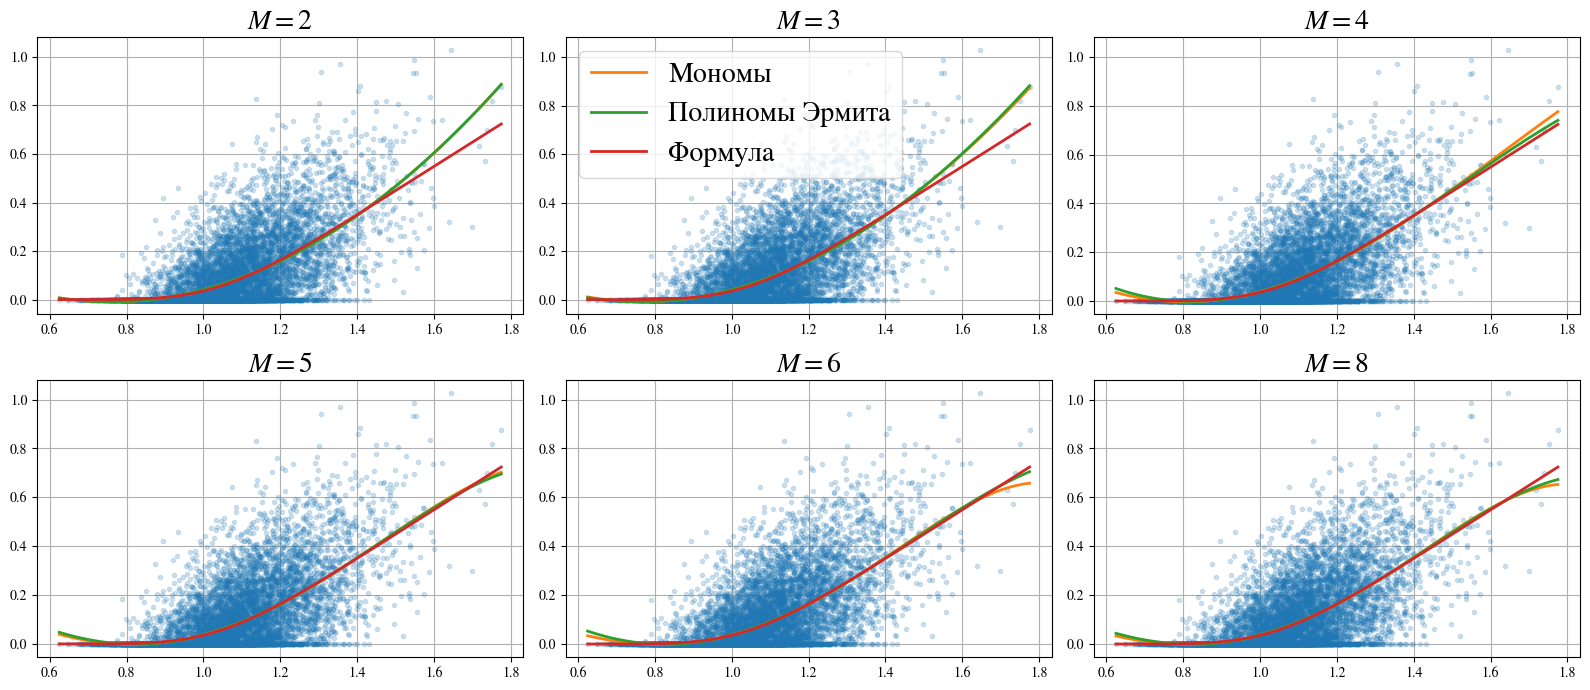

In [5]:
T2 = 1
nt = 104
nsim = 10000
tn = np.linspace(0, T2, nt + 1)

S = 1
sigma = 0.2
r = 0.1
strike = S * np.exp(r * T2)

T1 = tn[nt // 2]


spots = sample_gbm(tn, nsim, S, r, sigma)
X = spots[nt // 2]
Y = np.exp(-r * (T2 - T1)) * (spots[-1] - strike).clip(0.0)

spot_prices_grid = np.linspace(X.min(), X.max(), 100)
true_price = BS_call_price(spot_prices_grid, r, sigma, strike, (T2 - T1))

degrees = [2, 3, 4, 5, 6, 8]

fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax = ax.reshape(-1)

for i, degree in enumerate(degrees): 
    model = PolynomialRegression(degree)
    model.fit(X, Y)

    model_hermit = HermiteRegression(degree)
    model_hermit.fit(X, Y)

    
    predict = model.predict(spot_prices_grid)
    predict_hermit = model_hermit.predict(spot_prices_grid)
    ax[i].plot(X, Y, '.', alpha=0.2)
    ax[i].plot(spot_prices_grid, predict, lw=2, label='Мономы')
    ax[i].plot(spot_prices_grid, predict_hermit, lw=2, label='Полиномы Эрмита')
    ax[i].plot(spot_prices_grid, true_price, lw=2, label='Формула')
    #ax[i].legend(fontsize=15)
    ax[i].grid()
    ax[i].set_title(rf"$M={degree}$", fontsize=20)
ax[1].legend(fontsize=20)
fig.tight_layout()
plt.show()

## Double MC example

In [6]:
nsims2 = np.r_[1, 4, 10, 20, 50, 100]

preds = []
preds_h = []
Ys = []

degree = 4

for nsim2 in nsims2:
    Y = np.zeros(nsim)
    for j in range(nsim):
        # secondary samples
        sample = sample_gbm(tn[nt // 2:], nsim2, X[j], r, sigma, match=False)
        Y[j] = np.exp(-r * (T2-T1)) * (sample[-1] - strike).clip(0.0).mean()
    Ys.append(Y)
    model = PolynomialRegression(degree)
    model.fit(X, Y)

    model_hermit = HermiteRegression(degree)
    model_hermit.fit(X, Y)
    
    preds.append(model.predict(spot_prices_grid))
    preds_h.append(model_hermit.predict(spot_prices_grid))

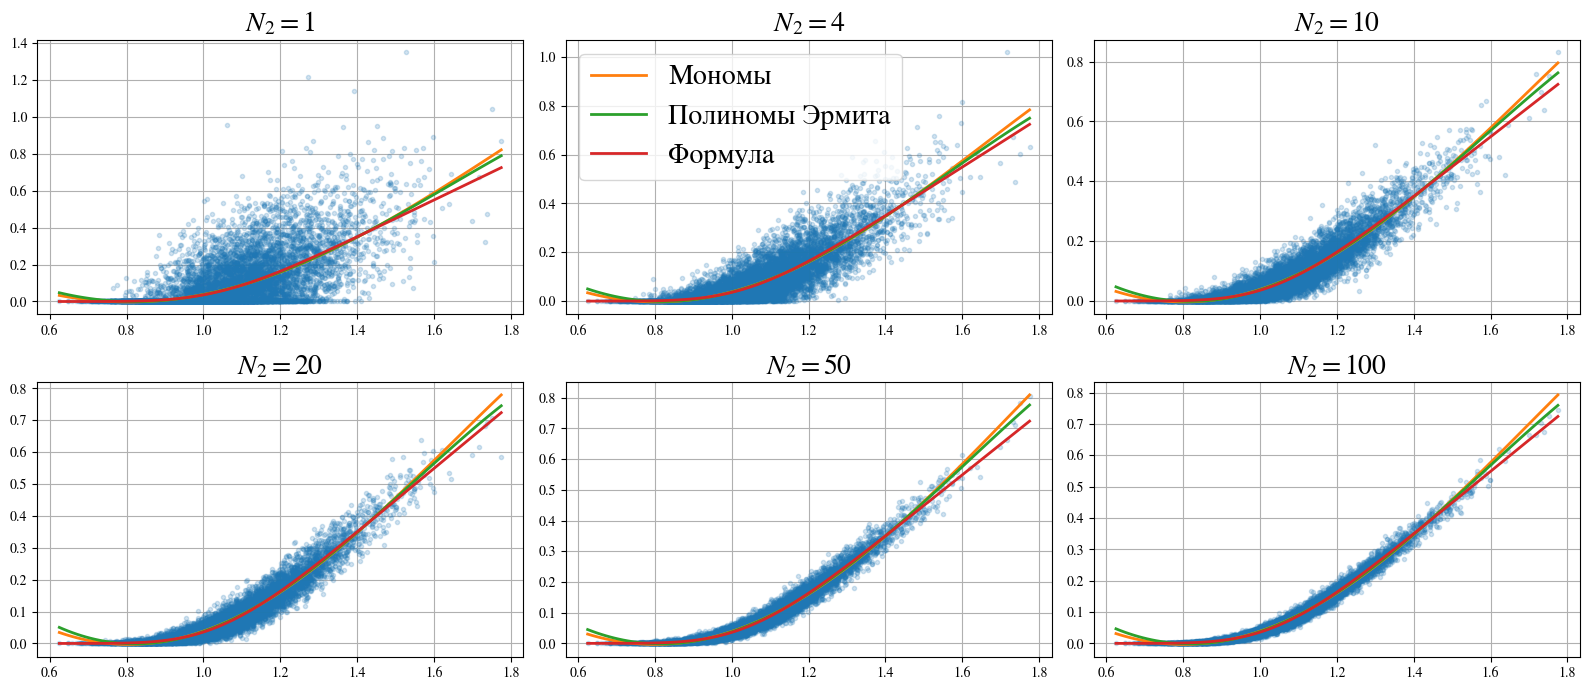

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))
ax = ax.reshape(-1)

for i, nsim2 in enumerate(nsims2): 
    ax[i].plot(X, Ys[i], '.', alpha=0.2)
    ax[i].plot(spot_prices_grid, preds[i], lw=2, label='Мономы')
    ax[i].plot(spot_prices_grid, preds_h[i], lw=2, label='Полиномы Эрмита')
    ax[i].plot(spot_prices_grid, true_price, lw=2, label='Формула')
    ax[i].grid()
    ax[i].set_title(rf"$N_2={nsim2}$", fontsize=20)
ax[1].legend(fontsize=20)
fig.tight_layout()
plt.show()